# Pytorch: Introduction

This is a simple introduction to PyTorch library and its capabilities as a ML library.

We will try to use CUDA (Compute Unified Device Architecture) to use this device's Graphics card. This notebook will be loosely following the [PyTorch Tutorials](https://pytorch.org/tutorials/beginner/basics/intro.html).

## 1. Prerequesites

First, we need to setup the environment, load libraries.

In [1]:
# Show if the system has installed an Nvidia graphics card
! lspci | grep "3D controller"

01:00.0 3D controller: NVIDIA Corporation GP107M [GeForce GTX 1050 Mobile] (rev a1)


In the case the output of the preceding command is emtpy, CUDA is not available in your PC. There are multiple resources on the web where you can check different solutions for your situation. [This one](https://stackoverflow.com/questions/60987997/why-torch-cuda-is-available-returns-false-even-after-installing-pytorch-with) in particular shows how to check if your graphics card can be accesible, and in the case it isn't, what other options do you have. Also, PyTorch has [excellent resources](https://pytorch.org/get-started/locally/) that explain different installation methods for different architectures/OSs.

In [2]:
import torch

# Is PyTorch capable of use NVidia card?
if torch.cuda.is_available():
    print("Yes, you have CUDA available.")
else:
    print("Only CPU is available.")

Yes, you have CUDA available.


Now, load dataset libraries.

In [3]:
from torch import nn
from torch.utils.data import DataLoader # Iterable of samples
from torchvision import datasets # Object to access dataset
from torchvision.transforms import ToTensor

The Fashion MNIST dataset is used. I will list resources to the relevant documentation for this dataset:
 * [FashionMNIST class](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html#fashionmnist)
 * [VisionTorch library index](https://pytorch.org/vision/stable/genindex.html)
 * [VisionDataset](https://pytorch.org/vision/stable/generated/torchvision.datasets.VisionDataset.html#visiondataset), the base class for MNIST which in turn is the base class for FashionMNIST.

Also relevant for this code:
 * [ToTensor()](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html#totensor) method on the images.
 * [PIL library](https://pypi.org/project/pillow/) was the Python Image Library. Now it's no longer maintained, however there's a fork called Pillow. This type of [objects](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image) are the ones to load images into the TorchVision env.

In [4]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data", # It's where the dataset is going to be saved (e.g. in "./data/" dir)
    train=True, # Create dataset from train-images-idx3-ubyte
    download=True, # Download dataset from the internet (only if it doesn't exits already locally
    transform=ToTensor(), # Transformation on a PIL image into a 3d matrix scaled (Color x Height x Width) (that's what ToTensor() does)
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # Create dataset from t10k-images-idx3-ubyte
    download=True,
    transform=ToTensor(),
)

Next step is to use a [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) to wrap up the datasets.

In [5]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


For now, we will display a small sample of images from the test dataset.

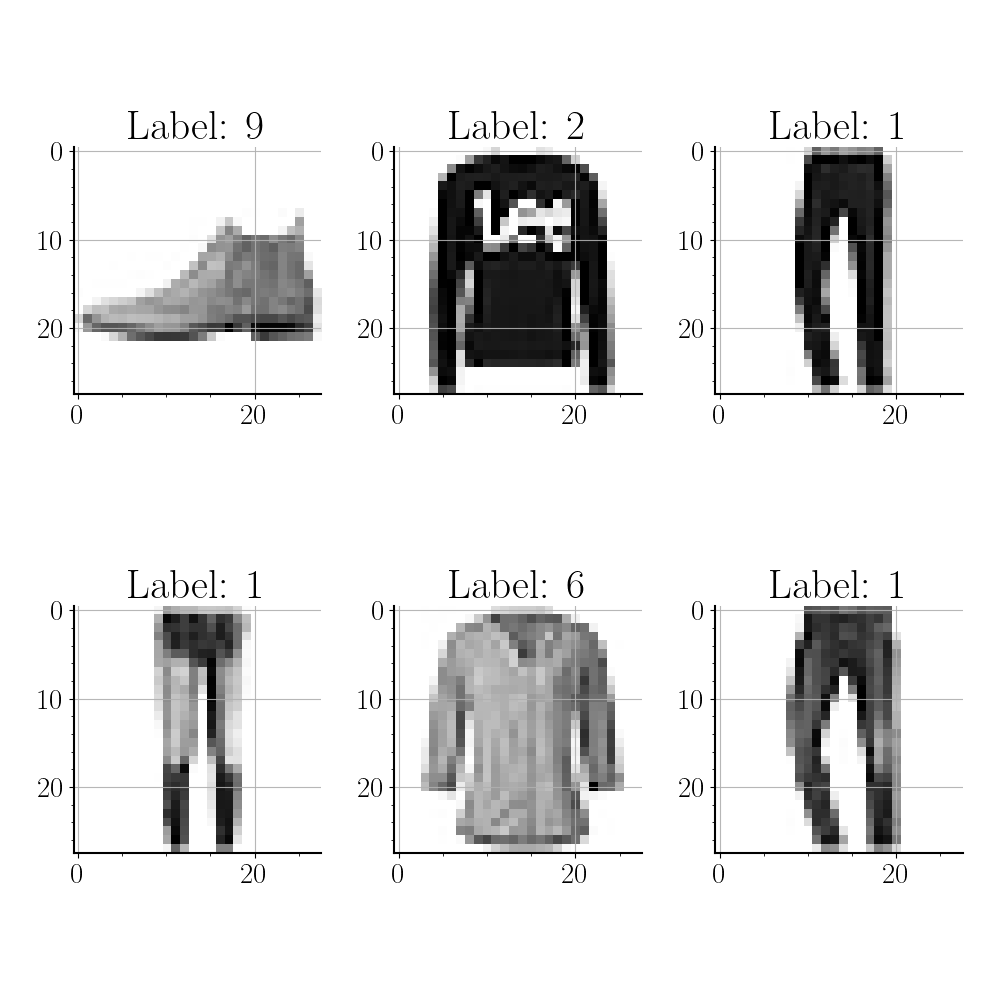

In [6]:
import matplotlib.pyplot as plt
%matplotlib widget

Nrows, Ncols = 2,3

fig, ax = plt.subplots(Nrows, Ncols, figsize=(10,10))
ax = ax.reshape(-1)

ims, lbls = None, None
for X, y in test_dataloader:
        

    ims = X[:ax.shape[0],0]
    lbls = y[:ax.shape[0]]
    break

for i, (im, lbl) in enumerate(zip(ims, lbls)):
    ax[i].imshow(im, 'Greys')
    ax[i].set_title("Label: " + str(lbl.item()))



We can discern from the sample images that a label of value 1 is used to classify trousers. This doesn't come as a surprise since this is the [actual label](https://github.com/zalandoresearch/fashion-mnist?tab=readme-ov-file#labels) for trousers.

We may proceed to define our model. We will use a neural network. We will define a class model from [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#module). We will use our GPU with this model. In case CUDA endpoint is not available, use CPU. For MPS devices there is an [article](https://pytorch.org/docs/stable/notes/mps.html#mps-backend) explaining what it is and how to use it. Also, for relevant documentation:
 * [nn.Linear](https://pytorch.org/docs/stable/notes/mps.html#mps-backend) for a linear transformation.
 * [nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#relu), Rectified Linear Unit fuction.
 * [nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#sequential), combine multiple functions in a cascading way.
 * [nn.Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html#flatten), flat the 1x28x28 image into a single 1D vector.

In [7]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            # Layer 1
            nn.Linear(28*28, 512),
            nn.ReLU(),

            # Layer 2
            nn.Linear(512, 512),
            nn.ReLU(),

            # Layer 3
            # Output must be a one-hot encoding for the labels
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## Model trainning

First, we need a loss function and an optimizer. Since we're dealing with a classification problem, a good choice is the cross entropy for the loss function. The cross entropy is a measure of the difference between two probabilities distributions over the same set of outcomes, one being the real distribution *p* and the other being estimated, *q*. The larger the entropy grows, the more amount of information the probability distribution *q* conveys. For discrete cases, the formula is,
$$
H(q,p) = - \sum_{x\in \chi} p(x) \log{q(x)}
$$
where $\chi$ is the set of all possible outcomes for both probabilities, $p(x)$ is the true probability of event $x$ and $q(x)$ is the estimated probability of event $x$.

In machine learning, _q_ is the probabilities of the classes as the output of the model and _p_ is the expected outcome (target data). Since in this case, we only expect one class for each input, the cross entropy is only the negative log of the estimated probability of the expected class.

For more information:
 * (Pytorch Cross-Entropy documentation)[https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#crossentropyloss]

Secondly, we need to define an algortihm to train the model with. One of the most popular algorithms is Stochastic Gradient Descend (SGD). This method computes the gradient for the model fixing the input data and considering only the parameters. One must assume that the parameter space is smooth. This is, for a model _m_, a cost function _C_, input _x_ and paramters $\omega$,
$$
\frac{ \partial C(m;x;\omega) } {\partial \omega_i}
$$
exists for any parameter values. We can imagine this as a smooth 2D curved surface, where $z = f(x,y)$ measures the cost of the model. To find a minimum cost (i.e. the model is close to predict the output from the input data), we must find a minimum in that space. We usually work with many parameters so this space has too many dimensions and the model is too complex to find a theoretical minimum. We make an approach by starting at a random state, and finding a path to go to a lower cost by "_stepping_" in the direction of the gradient. Each step is made updating the gradient for the new state of the model.

Since this approach only takes into consideration local changes of the model in the parameter space, the initial state actually impacts the final state of the model. There are multiple strategies to reduce this impact.

All of this means, however, that we need to find the gradient for a function with (in this case) $(28 * 28 + 1) * 512 + (512 + 1) * 512 + (512 + 1) * 10 = 669706$ dimensions. Also, in a FCN, we need to use start from the output and use the chain rule for derivates to work our way backwards to a neuron where the parameter lies. This is called backpropagation and there's a great analysis described in [here](https://en.wikipedia.org/wiki/Backpropagation#Finding_the_derivative_of_the_error) explaining how to compute it. Fortunately, PyTorch computes this in the background and we don't need to worry 😀.

More information:
 * [PyTorch documentation on SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)
 * [PyTorch optmizer step](https://pytorch.org/docs/stable/optim.html#taking-an-optimization-step)

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) # Learning rate = 0.001

Define a training function that loops over the whole dataset. Each iteration takes in a batch of data to train the model in a single step.

For reference:
 * [.to()](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html#torch-tensor-to)
 * [Evaluation mode](https://pytorch.org/docs/stable/notes/autograd.html#evaluation-mode-nn-module-eval)
 * [Backward step](https://pytorch.org/docs/stable/optim.html#taking-an-optimization-step)
 * [How PyTorch keeps history of operations for a model](https://pytorch.org/docs/stable/optim.html#taking-an-optimization-step)

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train() # Set train mode
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step() # Learning time!
        optimizer.zero_grad() # Reset gradient values to 0

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [10]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() # Set evaluation mode
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Now, loop to train the model. Each loop iterates over the whole dataset once. Test each loop to measure accuracy in each step.

In [11]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.309991  [   64/60000]
loss: 2.293822  [ 6464/60000]
loss: 2.282763  [12864/60000]
loss: 2.273547  [19264/60000]
loss: 2.249767  [25664/60000]
loss: 2.229435  [32064/60000]
loss: 2.237863  [38464/60000]
loss: 2.206427  [44864/60000]
loss: 2.211613  [51264/60000]
loss: 2.176404  [57664/60000]
Test Error: 
 Accuracy: 43.8%, Avg loss: 2.167939 

Epoch 2
-------------------------------
loss: 2.183100  [   64/60000]
loss: 2.168104  [ 6464/60000]
loss: 2.120545  [12864/60000]
loss: 2.135366  [19264/60000]
loss: 2.076943  [25664/60000]
loss: 2.023200  [32064/60000]
loss: 2.060343  [38464/60000]
loss: 1.982181  [44864/60000]
loss: 2.001226  [51264/60000]
loss: 1.921948  [57664/60000]
Test Error: 
 Accuracy: 57.8%, Avg loss: 1.917700 

Epoch 3
-------------------------------
loss: 1.955093  [   64/60000]
loss: 1.920069  [ 6464/60000]
loss: 1.815478  [12864/60000]
loss: 1.852953  [19264/60000]
loss: 1.723304  [25664/60000]
loss: 1.681629  [32064/600

# Saving and loading modules

PyTorch can save model parameters calling [state_dict()](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.state_dict) and save them into a file. However, this will only save the parameters and not the model as a whole, so you need to instance the model object before loading the parameters into it. PyTorch uses the pickle module to [save the model object](https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html#saving-and-loading-models-with-shapes) and its parameters into a file.

In [12]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")


Saved PyTorch Model State to model.pth


Load the model into memory.

In [13]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

Make a simple use of the model to predict a class for the first image.

In [14]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad(): # No need to record gradients while computing
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


We can also list individual parameters of the model accessing by name.

In [15]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[ 0.0200, -0.0246, -0.0192,  ..., -0.0333,  0.0140,  0.0117],
        [ 0.0226, -0.0126, -0.0226,  ...,  0.0041,  0.0096, -0.0199]],
       device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([0.0283, 0.0315], device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[ 0.0434, -0.0065, -0.0232,  ..., -0.0072,  0.0061,  0.0048],
        [-0.0226,  0.0270, -0.0118,  ...,  0.0279, -0.0107,  0.0024]],
       device='cuda:0', grad_fn=<Slic